**Imports**

In [82]:
!pip install pyccel
!pip install numba
import numpy as np
import scipy as sp
from scipy import special as ss
import scipy.linalg as lg
import matplotlib.pyplot as pl

import time
from time import process_time


from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types,pure


**Pure python function**

In [83]:

def Bpyccel(n,k,t,C0):
  return C0[n,k]*((1-t)**(n-k))*(t**k)                    #polynome de Bernstien

def factorisation_pure(d,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs):
  iteration=0
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            c=0.
            for r in range(0,q):
              c=c+(grs*w1[r]*Bpyccel(d,alpha1,ita1[r],C0)*Bpyccel(d,bita1,ita1[r],C0))
            cMalphaBihaApp=cMalphaBihaApp+c*w0[s]*Bpyccel(d-alpha1,alpha2,ita0[s],C0)*Bpyccel(d-bita1,bita2,ita0[s],C0)  
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1      
    

  return 0

**Numba accelerator**

In [84]:
@njit
def Bpyccel(n,k,t,C0):
  return C0[n,k]*((1-t)**(n-k))*(t**k)                #polynome de Bernstien
@njit
def factorisation_numba(d,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs):

  iteration=0
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            c=0.
            for r in range(0,q):
              c=c+(grs*w1[r]*Bpyccel(d,alpha1,ita1[r],C0)*Bpyccel(d,bita1,ita1[r],C0))
            cMalphaBihaApp=cMalphaBihaApp+c*w0[s]*Bpyccel(d-alpha1,alpha2,ita0[s],C0)*Bpyccel(d-bita1,bita2,ita0[s],C0)  
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1      
    

  return 0

**Pyccel accelerator**

In [85]:

@types('int','int','float[:]','float[:]','float[:]','float[:]','float[:]','float[:,:]','float')
def factorisation_pyccel(d,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs):
  @types('int','int','float','float[:,:]')
  def Bpyccel(n,k,t,C0):
    return C0[n,k]*((1-t)**(n-k))*(t**k)                            #polynome de Bernstien
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            c=0.
            for r in range(0,q):
              c=c+(grs*w1[r]*Bpyccel(d,alpha1,ita1[r],C0)*Bpyccel(d,bita1,ita1[r],C0))
            cMalphaBihaApp=cMalphaBihaApp+c*w0[s]*Bpyccel(d-alpha1,alpha2,ita0[s],C0)*Bpyccel(d-bita1,bita2,ita0[s],C0)  
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1

  return 0

**Epyccel function**

In [86]:
factorisation=epyccel(factorisation_pyccel,language='fortran')

**Inputs**

In [88]:
C0=sp.diag(sp.ones(500))
C0[:,0]=sp.ones(500)
for n in range(1,500):                                   # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m] 


def JT(x):
  return sp.array([[1,2],[-1,0]])                          #Jacobien de FT
  
  
  
def F(x):
  return sp.array([x[0],(1-x[0])*x[1]])                    #Transformation de Duffy


iteration=0

itars=sp.array([0,0])
zetars=F(itars)
grs=lg.det(JT(zetars))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel

In [98]:
degremax=100




**Time for function with pyccel accelerator**

In [90]:
temCPUpyccelF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)                   #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)

  t1P= process_time()
  factorisation(i,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs)
  t2P= process_time()

  temCPUpyccelF.append(t2P-t1P)


**Time for function with numba accelerator**

In [99]:
temCPUnumbaF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)

  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)          #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)

  t1N= process_time()
  factorisation_numba(i,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs)
  t2N= process_time()

  temCPUnumbaF.append(t2N-t1N)

**time for pure function**

In [92]:
temCPUpureF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)

  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)             #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)

  t1r= process_time()
  factorisation_pure(i,iteration,ita0,w0,ita1,w1,malphaBihaApp,C0,grs)
  t2r= process_time()

  temCPUpureF.append(t2r-t1r)

**Plot**

**Plot pyccel function**

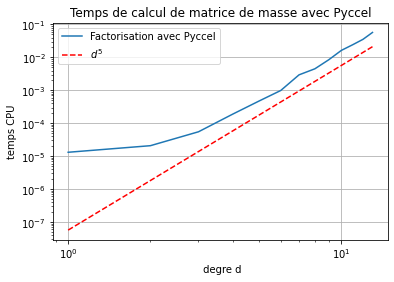

In [93]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpyccelF,label='Factorisation avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec Pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=5.7*(10**(-8))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**plot numba function**

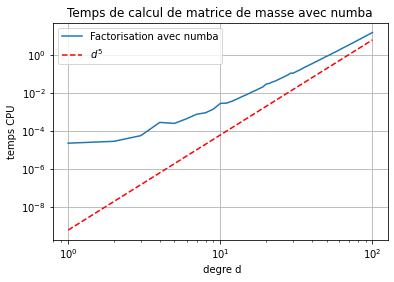

In [100]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUnumbaF,label='Factorisation avec numba')
pl.title("Temps de calcul de matrice de masse avec numba")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=6*(10**(-10))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**Plot pure function**

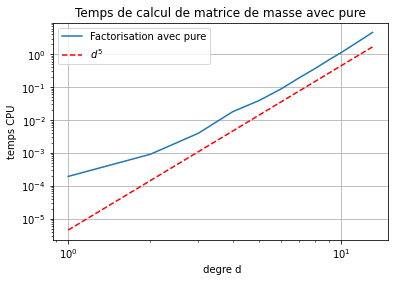

In [96]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpureF,label='Factorisation avec pure')
pl.title("Temps de calcul de matrice de masse avec pure")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-6))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**Plot pure, numba and pyccel functions**

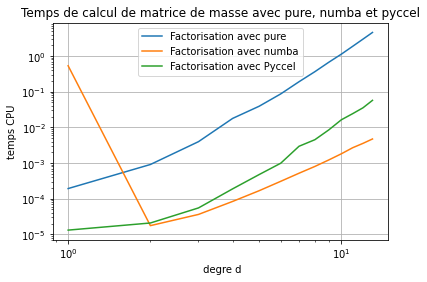

In [97]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpureF,label='Factorisation avec pure')
pl.plot(degre,temCPUnumbaF,label='Factorisation avec numba')
pl.plot(degre,temCPUpyccelF,label='Factorisation avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec pure, numba et pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-10))
Z=cst*(Degre**5)
#pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 